In [4]:
import cv2
import numpy as np

def save_image(image,addr,num):
    address = addr + str(num)+ '.jpg'
    cv2.imwrite(address,image)

videoCapture = cv2.VideoCapture("20.mp4")
success, frame = videoCapture.read()
pic_num = 0
while success:
    pic_num = pic_num + 1
    save_image(frame,'D:/output/image',pic_num)
    success, frame = videoCapture.read()
n=pic_num
print(pic_num)

140


[[  3.05306672e-07  -8.15381521e-07   2.04738237e-04]
 [  8.16440333e-07   3.31511970e-07  -1.30613637e-03]
 [ -7.33660002e-04  -6.25017275e-05   1.00000000e+00]]
3 position:  [-1386.28351948] [-747.57326583]


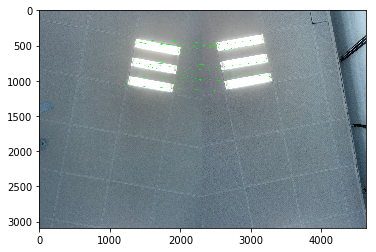

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def median(data):
        data.sort()
        half = len(data) // 2
        return (data[half] + data[~half])/2

def get_position(img1,img2):
    sift = cv2.xfeatures2d.SIFT_create()
    indexParams = dict(algorithm=0, trees=5)
    searchParams = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(indexParams,searchParams)
    kp1,desc1 = sift.detectAndCompute(img1,None)
    kp2,desc2 = sift.detectAndCompute(img2,None)
    raw_matches = matcher.knnMatch(desc1, desc2, 2)
    good = []
    for m,n in raw_matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>10:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC,5.0)
        img2 = cv2.warpPerspective(img2, np.array(M), (img2.shape[1], img2.shape[0]), flags=cv2.WARP_INVERSE_MAP)
        cv2.imshow("img1:",img1)
        cv2.waitKey(0)
        cv2.imshow("img2:",img2)
        cv2.waitKey(0)
        matchesMask = mask.ravel().tolist()
    else:
        print("Not enough matches are found - %d/%d" % (len(good),10))
        matchesMask = None
    
    
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                         singlePointColor = (0,0,255),
                         matchesMask = matchesMask, 
                         flags = 2)# draw only inliers 

    vis = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)   
    plt.imshow(vis)
    point_num=len(good)
    all_x=0
    all_y=0
    this_x=[]
    this_y=[]


    for i in range(0,point_num-1):
        num=0
        j=good[i].trainIdx
        k=good[i].queryIdx
        ex_pos=[kp2[j].pt[0],kp2[j].pt[1],1]

            
        ex_pos_np=np.array(ex_pos)
        ex_pos_T=np.transpose([ex_pos_np])
        pos=np.matmul(M,ex_pos_T)

        this_x.append(pos[0]-kp1[k].pt[0])
        this_y.append(pos[1]-kp1[k].pt[1])

    max_x=median(this_x)+10
    min_x=median(this_x)-10
    max_y=median(this_y)+10
    min_y=median(this_y)-10

    for i in range(0,point_num-1):    
        if(matchesMask[i]!=0):
            if((this_x[i]<max_x)&(this_x[i]>min_x)&(this_y[i]<max_y)&(this_y[i]>min_y)):
                all_x+=this_x[i]
                all_y+=this_y[i]
                num+=1
    if num==0:
        delta_x=0
        delta_y=0
        print("no match")
        
    else:
        delta_x=all_x/num
        delta_y=all_y/num
        
    return [delta_x,delta_y]

x=0
y=0
for pic_num in range(3,4):
#        img_path1="D:/output/image"+str(pic_num-1)+".jpg"
        img_path1="D:/output/3.png"
        img1 = cv2.imread(img_path1)
#        img_path2="D:/output/image"+str(pic_num)+".jpg"
        img_path2="D:/output/4.png"
        img2 = cv2.imread(img_path2)
        delta_x,delta_y=get_position(img1,img2)
        x+=delta_x
        y+=delta_y
        print(pic_num,"position: ",x,y)